In [54]:
import networkx as nx
import json
import matplotlib.pyplot as plt
import powerlaw
import numpy as np
from sklearn.linear_model import LinearRegression
import statistics
from scipy import stats

In [37]:
seed = 42

# Network Summary

## Data mining and preprocessing, general charachteristics, basic visualization

This network represents a schema of figure skaters following each other on Instagram (designated as an extremist organization by the Russian government). The data was collected manually by downloading HTML pages from Instagram accounts. Since Instagram uses dynamic page updates, I utilized the `copy_outer_html` function to extract the data. Subsequently, the `BeautifulSoup` was utilized for parsing. Only publicly available accounts were collected to comply with Instagram's policies. 

The downloaded data can be found in the `insta_follows` folder, the complete preprocessing workflow can be found in `data_parsing.py`, and the graph itself in JSON-format is located in `fs_inst_following.json`. Graph attributes, including point scores and full names, were collected from the [Official ISU website](https://www.isuresults.com/bios/). Links to the pages were manually gathered and can be found in `FS_nicks_links.csv`. In cases where automatic parsing was not possible, scores were calculated manually and stored in this CSV table. The parsing code is available in `isu_site_parsing.py`.

The data was collected using a balanced sampling approach. Figure skating comprises four disciplines: **women's singles**, **men's singles**, **pairs**, and **ice dance**. To minimize bias, an equal number of skaters was selected from each category: 26 women's singles skaters, 26 men's singles skaters, 26 pairs skaters (comprising 13 men and 13 women), 26 ice dance skaters (similarly, 13 men and 13 women). In total, 104 accounts were analyzed.

The network thus has the following charachteristics:
- each node represents an athlete's Instagram account; there are **104 nodes** in total;
- overall, **2324 edges** are represented;
- each directed edge represents a "following" relationship between two accounts, meaning the network is **directed**;
- all edges have equal weight, meaning the network is **unweighted**;
- the set of nodes is **homogeneous**, as all individuals belong to the same professional community (elite figure skating).

The nodes have following attributes:
- figure skating discipline;
- a merit-based point score for each skater, calculated according to [ISU World Standings and Season's World Ranking](https://en.wikipedia.org/wiki/ISU_World_Standings_and_Season%27s_World_Ranking);
- athlete's full name

All mentioned scripts, full dataset, this notebook, and the project presentation are available on the [project's GitHub page](https://github.com/vixbi/social_network_project).

In [38]:
with open('fs_inst_following.json', 'r', encoding='utf-8') as f:
    graph_dict = json.load(f)

In [3]:
G = nx.DiGraph()

G.add_nodes_from(graph_dict.keys())
for follower, following_list in graph_dict.items():
    for following in following_list:
        if following in graph_dict.keys():
            G.add_edge(follower, following)

# short descriptives
print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")

Nodes: 104, Edges: 2324


In [6]:
with open("graph_attributes.json") as f:
    graph_attributes = json.load(f)

for node in G.nodes:
    for attr_name, attr_value in graph_attributes[node].items():
        G.nodes[node][attr_name] = attr_value
print(G.nodes["anna__shcherbakova_"])

{'name': 'Anna SHCHERBAKOVA', 'discipline': 'LS', 'score': 4446}


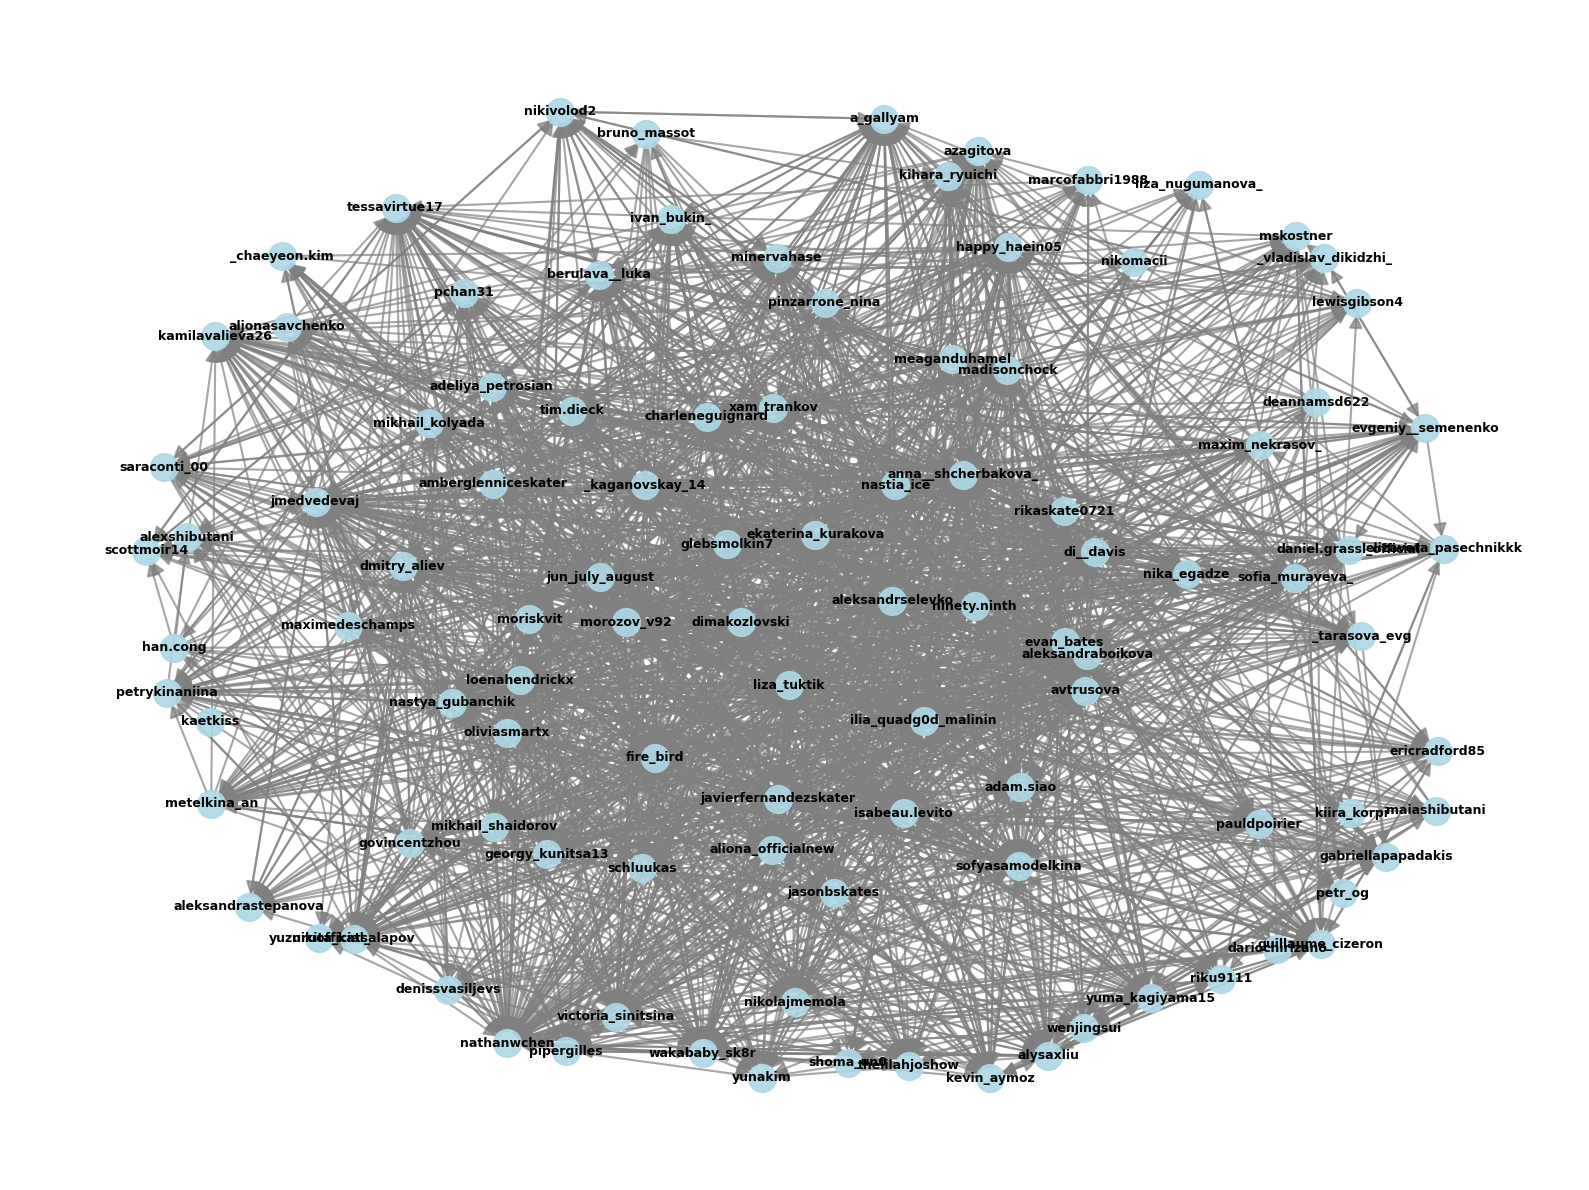

In [7]:
# basic visualization
plt.figure(figsize=(16, 12))
pos = nx.spring_layout(G, k=2, iterations=50, seed=42)

nx.draw_networkx_nodes(G, pos, node_size=400, node_color='lightblue', alpha=0.9)
nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, arrowsize=20, width=1.5, alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=9, font_weight='bold')

plt.axis('off')

plt.tight_layout()
plt.show()

## Degree distribution: checking whether the network is scale-free

To determine whether a network exhibits scale-free properties, we need to examine whether its degree distribution follows a power law. Since I was working with a directed graph, I was to analyze the distribution of total degrees for each node, calculated by summing the in-degree and out-degree values for every node.

The Kolmogorov-Smirnov test was used to assess the goodness-of-fit between the empirical degree distribution and a theoretical power-law model. To perform this analysis, a `Fit` object from the `powerlaw` library was created. It automatically fits a power-law distribution to the data by finding the optimal lower bound (`xmin`) where the power-law behavior begins. The fit's quality (goodness of fit) is quantified by the Kolmogorov-Smirnov statistic (D) (`.KS()` method). This statistic measures the maximum distance between the  CDF of the empirical data and the CDF of the fitted theoretical power-law model. A smaller D value indicates a better fit.

In [8]:
degrees = [G.in_degree()[node] + G.out_degree()[node] for node in G.nodes]

In [48]:
fit = powerlaw.Fit(degrees, discrete=True, verbose=False)
print(f"Optimal lower bound: {fit.xmin}")
print(f"Power law exponent (alpha): {fit.alpha:.3f}")
print(f"D-value of Kolmogorov-Smirnov test: {fit.power_law.KS():.3f}")

Optimal lower bound: 49.0
Power law exponent (alpha): 4.710
D-value of Kolmogorov-Smirnov test: 0.115


The analysis of the empirical degree distribution using the Kolmogorov-Smirnov goodness-of-fit test indicates that the observed network does not exhibit scale-free properties: the usual threshold for satiafactory fitting is <.05, and we have 0.115. 

I compared the empirical distribution against a theoretical null model using a random network of comparable size and density. For this purpose, the Barabási–Albert random graph model will be implemented to generate a graph with an equal number of nodes and an approximate matching of the average degree. This model was chosen because it provides an opportunity to generate scale-free random network.

In [31]:
G_undirected = G.to_undirected()
n = G_undirected.number_of_nodes()
m = int(G_undirected.number_of_edges() / n)
random_BA = nx.barabasi_albert_graph(n, m)
random_degrees = [i for i in dict(random_BA.degree).values()]

fit = powerlaw.Fit(random_degrees, discrete=True, verbose=False)
print(f"Optimal lower bound for random graph: {fit.xmin}")
print(f"Power law exponent (alpha) for random graph:: {fit.alpha:.3f}")
print(f"D-value of Kolmogorov-Smirnov test for random graph:: {fit.power_law.KS():.3f}")

Optimal lower bound for random graph: 27.0
Power law exponent (alpha) for random graph:: 3.871
D-value of Kolmogorov-Smirnov test for random graph:: 0.072


As evident from the analysis, the random Barabási-Albert network exhibits a degree distribution that follows the power-law, whereas the created network does not demonstrate an appropriate fit to this model, as indicated by the Kolmogorov-Smirnov test values.

Additionally, I conducted a pairwise statistical KS-test to calculate the p-value and determine whether the degree distributions of our empirical network and the random Barabási-Albert model differ significantly.

In [55]:
_, p_value = stats.ks_2samp(degrees, random_degrees)
print(f"P-value: {p_value:.3f}")

P-value: 0.000


The extremely small p-value indicates a statistically significant difference between the degree distributions. Therefore, we reject the null hypothesis that the two distributions are identical. This finding suggests that the observed network **is not scale-free**.

## Average distance 

Unfortunately, the graph lacks strong connectivity. Consequently, when running the following code:
```
print('Radius: ', nx.radius(G))
print('Diameter: ', nx.diameter(G))
print('Average shortest path length: ', nx.average_shortest_path_length(G))
```
I get the following error:
`NetworkXError: Found infinite path length because the digraph is not strongly connected.`
Some nodes are unreachable, therefore, I focused on the analysis of largest strongly connected component of the graph.

In [40]:
# getting the list of strongly connected components
strongly_connected = nx.strongly_connected_components(G)

# finding the largest component
largest_component_nodes = max(list(strongly_connected), key=len)
largest_component = G.subgraph(largest_component_nodes)
print(f"Nodes: {largest_component.number_of_nodes()}, Edges: {largest_component.number_of_edges()}")

Nodes: 98, Edges: 2249


Fortunately, the largest connected component does not appear to differ significantly from the original graph: it contains only 6 fewer nodes and 75 fewer edges. This indicates that we can conduct distance analysis with a high degree of confidence. Clustering coefficient was calculated for the full graph.

In [41]:
print(f'Actual Radius: {nx.radius(largest_component)}')
print(f'Actual Diameter: {nx.diameter(largest_component)}')
print(f'Actual average shortest path length: {nx.average_shortest_path_length(largest_component):.3f}')
print(f'Actual average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.3f}')
print(f"Actual clustering coefficient: {nx.average_clustering(G):.3f}")

Actual Radius: 3
Actual Diameter: 4
Actual average shortest path length: 1.871
Actual average degree: 44.692
Actual clustering coefficient: 0.390


Now let's compare this results to the random network generated by Watts-Strogatz algorithm in order to check whether the created network is a small world. If the metrics do not differ significantly, we can say that our network is a small world by the assumption that random networks represent small world features.

In [43]:
n = G_undirected.number_of_nodes()
avg_degree = sum(dict(G_undirected.degree()).values()) / n
k = int(round(avg_degree))
random_WS = nx.watts_strogatz_graph(n, k, p=0.1, seed=seed)

In [44]:
print(f'Theoretical random network  Radius: {nx.radius(random_WS)}')
print(f'Theoretical random network Diameter: {nx.diameter(random_WS)}')
print(f'Theoretical random network average shortest path length: {nx.average_shortest_path_length(random_WS):.3f}')
print(f'Theoretical random network average degree: {sum(dict(random_WS.degree()).values()) / random_WS.number_of_nodes():.3f}')
print(f"Theoretical random network clustering coefficient: {nx.average_clustering(random_WS):.3f}")

Theoretical random network  Radius: 2
Theoretical random network Diameter: 3
Theoretical random network average shortest path length: 1.684
Theoretical random network average degree: 34.000
Theoretical random network clustering coefficient: 0.582


The comparison reveals close similarity in average path lengths (1.684 vs. 1.871) and significant but not extreme differences in other metrics. To statistically validate whether these differences are meaningful, I performed a Kolmogorov-Smirnov test to check if the degree distributions significantly differ between the networks.

In [57]:
ws_degrees = [i for i in dict(random_WS.degree).values()]
_, p_value = stats.ks_2samp(degrees, ws_degrees)
print(f"P-value: {p_value:.3f}")

P-value: 0.000


The statistical test revealed different degree distributions, yet the average path lengths remain nearly identical (1.871 vs 1.684). This suggests that while connection patterns differ from random networks, the network still may achieve efficient global connectivity.

The lower clustering coefficient (0.390 vs 0.582) indicates that skaters' Instagram followings form fewer closed triangles than random connections would. This suggests professional rather than social networking patterns, where following reflects career awareness rather than mutual friendships. Combined with the short average path lengths, this reveals an efficiently connected but locally sparse professional network.

## Gorgeous network layout

# Structural Analysis

## Differences and similarity with ER/BA/WS models and the reasons for it

Finally, I generated a random graph following a Poisson degree distribution (Erdős–Rényi model) to test whether my network's structure is random. 

In [60]:
m = G.number_of_edges()
p = m/(n*(n-1)) 
random_ER = nx.erdos_renyi_graph(n, p, directed=True, seed=seed)

er_degrees = [random_ER.in_degree()[node] + random_ER.out_degree()[node] for node in random_ER.nodes]

_, p_value = stats.ks_2samp(degrees, er_degrees)
print(f"P-value: {p_value:.3f}")

P-value: 0.000


Performing a Kolmogorov-Smirnov test on the degree distributions yielded a very small p-value, indicating that my network's structure is statistically different from random and therefore unlikely to be explained by chance connections.

Here's a short summarization of what I've learned from comparing my network to ER/BA/WS models
| Model | Property to be extracted | p-value of KS-test | Other values (observed vs random) | Interpretation |
|-------|--------------------------|---------------------|--------------|----------------|
| **Erdős–Rényi model** | randomness of the network | ≈ 0 |  | degree distribution significantly different from random |
| **Barabási–Albert model** | scale-free feature presence | ≈ 0 | *Optimal lower bound:* 49 vs 27 <br> *Alpha*: 4.710 vs 3.871 <br> *D-value of KS*: 0.115 vs 0.072 | the resulting network is not scale-free |
| **Watts-Strogatz** | small-world presence | ≈ 0 | *Radius*: 3 vs 2 <br> *Diametr*: 4 vs 3 <br> *Average shortest path length*: 1.871 vs 1.684 <br> *Average Degree*: 44.692 vs 34 <br> *Clustering coefficient*: 0.39 vs  0.582 | the resulting network may have small world property |

## Centrality measures

## PageRank

## Degree mixing pattern

## Attributes mixing pattern. Why is your network assortative/disassortative by node attributes?

# Community detection

## Louvain method

## Girvan-Newman algorithm